MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

See Linkedin articles

Spectral Coherence between Gravity and Bathymetry Grids

https://www.linkedin.com/pulse/computing-coherence-between-two-dimensional-gravity-grids-pechnikov/

The Density-Depth Model by Spectral Fractal Dimension Index

https://www.linkedin.com/pulse/density-model-spectral-fractal-dimension-index-alexey-pechnikov/

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import linregress

import matplotlib.pyplot as plt
%matplotlib inline

## Console commands to prepare datasets

### reproject and crop area from local GEBCO_2019 topography dataset
rm -f GEBCO_2019.subset.32634.tif && gdalwarp -s_srs WGS84 -t_srs EPSG:32634 -te 480400 4213200 510400 4243200 -r bilinear -tr 200 200 GEBCO_2019.nc GEBCO_2019.subset.32634.tif

### reproject and crop area from local Sandwell and Smith Gravity Anomaly dataset
img2grd grav_28.1.img -Ggrav_28.1.nc -R0/360/-80.738/80.738 -S0.1 -V

rm -f grav_v28.subset.32634.tif && gdalwarp -s_srs WGS84 -t_srs EPSG:32634 -te 480400 4213200 510400 4243200 -r bilinear -tr 200 200 grav_28.1.nc grav_v28.subset.32634.tif

## Define functions

In [2]:
# band filter
def raster_filter_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) - gaussian_filter(raster.values,g2)
    return raster

def spectrum(raster, gammas):
    rasters = []
    for g in gammas:
        print (g,". ", end = '')
        _raster = raster_filter_range(raster, g-.5, g+.5)
        rasters.append(_raster)
    return rasters

def correlogram(rasters1, rasters2, gammas):
    corrs = []
    for ridx in range(len(gammas)):
        print (ridx+1,". ", end = '')
        _raster2 = rasters2[ridx]
        for didx in range(len(gammas)):
            _raster1 = rasters1[didx]
            df = pd.DataFrame({'r1': _raster1.values.flatten(), 'r2': _raster2.values.flatten()})
            corr = round((df.corr()).iloc[0,1],2)
            corrs.append(corr)

    da_corr = xr.DataArray(np.array(corrs).reshape([len(gammas),len(gammas)]),
                          coords=[resolution*gammas,resolution*gammas],
                          dims=['r2','r1'])

    return da_corr

## Define parameters

In [3]:
# rasters below defined in projected coordinates system (EPSG:32702)
GEBCO="GEBCO_2019.subset.32634.tif"
GRAVITY="grav_v28.subset.32634.tif"

# scale coefficient for rasters [km/pixel]
resolution = 0.2
# waveband in resolution units
GAMMA = 43
# waveband processing step
DGAMMA= 2

## Define discrete spectrum

In [4]:
gammas = np.arange(DGAMMA,GAMMA+DGAMMA/2,DGAMMA)

## Load rasters

### GEBCO_2019 topography

In [5]:
dem = xr.open_rasterio(GEBCO).rename({'x':'lon','y':'lat'})
dem

<xarray.DataArray (band: 1, lat: 150, lon: 150)>
array([[[-268.4246  , -272.38104 , ...,   -9.538813,  -10.693435],
        [-273.59122 , -276.77527 , ...,  -15.586879,  -16.314018],
        ...,
        [  41.64838 ,   47.61573 , ...,  -94.835205,  -94.28803 ],
        [  28.118279,   36.222824, ...,  -94.3534  ,  -93.74815 ]]],
      dtype=float32)
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 4.243e+06 4.243e+06 4.243e+06 ... 4.214e+06 4.213e+06
  * lon      (lon) float64 4.805e+05 4.807e+05 4.809e+05 ... 5.101e+05 5.103e+05
Attributes:
    transform:   (200.0, 0.0, 480400.0, 0.0, -200.0, 4243200.0)
    crs:         +init=epsg:32634
    res:         (200.0, 200.0)
    is_tiled:    0
    nodatavals:  (9.969209968386869e+36,)

### Sandwell and Smith Gravity Anomaly

In [6]:
grv = xr.open_rasterio(GRAVITY).rename({'x':'lon','y':'lat'})
grv

<xarray.DataArray (band: 1, lat: 150, lon: 150)>
array([[[-41.352573, -42.90181 , ..., -83.66933 , -83.699196],
        [-41.80888 , -43.335075, ..., -83.59911 , -83.63394 ],
        ...,
        [  2.260509,   1.453462, ..., -88.81238 , -89.19567 ],
        [  1.37682 ,   0.567361, ..., -88.50765 , -88.88996 ]]], dtype=float32)
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 4.243e+06 4.243e+06 4.243e+06 ... 4.214e+06 4.213e+06
  * lon      (lon) float64 4.805e+05 4.807e+05 4.809e+05 ... 5.101e+05 5.103e+05
Attributes:
    transform:   (200.0, 0.0, 480400.0, 0.0, -200.0, 4243200.0)
    crs:         +init=epsg:32634
    res:         (200.0, 200.0)
    is_tiled:    0
    nodatavals:  (nan,)

## Plot datasets

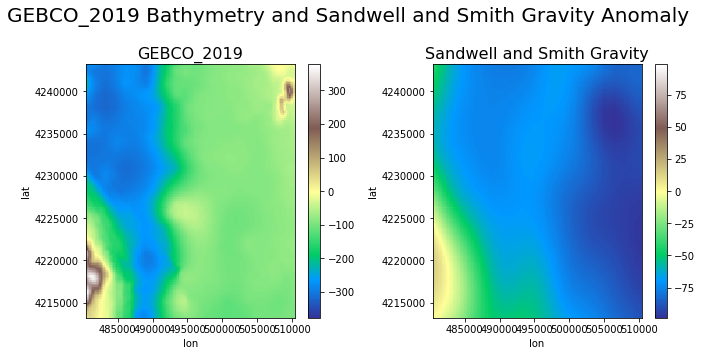

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

dem.plot(ax=ax1, cmap='terrain')
ax1.set_title('GEBCO_2019',fontsize=16)

grv.plot(ax=ax2, cmap='terrain')
ax2.set_title('Sandwell and Smith Gravity',fontsize=16)

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('GEBCO_2019 Bathymetry and Sandwell and Smith Gravity Anomaly',fontsize=20)
#plt.savefig('GEBCO_2019 and Sandwell and Smith Gravity Anomaly.jpg', dpi=150)
plt.show()


## Spectrums calculation

In [8]:
dems = spectrum(dem, gammas)
grvs = spectrum(grv, gammas)

2.0 . 4.0 . 6.0 . 8.0 . 10.0 . 12.0 . 14.0 . 16.0 . 18.0 . 20.0 . 22.0 . 24.0 . 26.0 . 28.0 . 30.0 . 32.0 . 34.0 . 36.0 . 38.0 . 40.0 . 42.0 . 2.0 . 4.0 . 6.0 . 8.0 . 10.0 . 12.0 . 14.0 . 16.0 . 18.0 . 20.0 . 22.0 . 24.0 . 26.0 . 28.0 . 30.0 . 32.0 . 34.0 . 36.0 . 38.0 . 40.0 . 42.0 . 

## Correlogram calculation

In [9]:
da_grv_corr = correlogram(dems, grvs, gammas)

1 . 2 . 3 . 4 . 5 . 6 . 7 . 8 . 9 . 10 . 11 . 12 . 13 . 14 . 15 . 16 . 17 . 18 . 19 . 20 . 21 . 

In [10]:
float(da_grv_corr.min()),float(da_grv_corr.max())

(0.02, 0.78)

## Plot correlogram

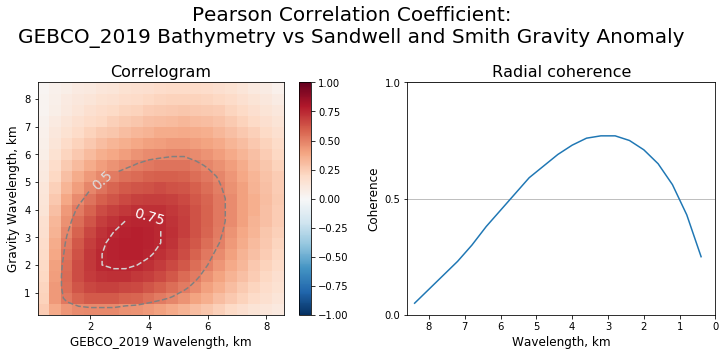

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

da_grv_corr.plot(cmap='RdBu_r',ax=ax1, vmin=-1,vmax=1)
contours = da_grv_corr.plot.contour(levels=[.5,.75],colors=['gray','lightgray'],linestyles='--',ax=ax1)
ax1.clabel(contours, contours.levels, inline=True, fmt='%r', colors=['gainsboro','white'], fontsize=14)
ax1.set_xlabel('GEBCO_2019 Wavelength, km',fontsize=12)
ax1.set_ylabel('Gravity Wavelength, km',fontsize=12)
ax1.set_title('Correlogram',fontsize=16)

ax2.plot(resolution*gammas, [float(da_grv_corr[g,g]) for g in range(len(gammas))])
ax2.set_xlabel('Wavelength, km',fontsize=12)
ax2.set_ylabel('Coherence',fontsize=12)
ax2.set_yticks([0,0.5,1])
ax2.yaxis.grid(True)
ax2.set_xlim([resolution*GAMMA,0])
ax2.set_title('Radial coherence',fontsize=16)

plt.suptitle('Pearson Correlation Coefficient:\nGEBCO_2019 Bathymetry vs Sandwell and Smith Gravity Anomaly',fontsize=20)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.85])
#plt.savefig('Pearson Correlation Coefficient: GEBCO_2019 vs Sandwell and Smith Gravity Anomaly.jpg', dpi=150)
plt.show()

## Fractal Dimension Index calculation

In [12]:
dem_stds = [_.std() for _ in dems]
grv_stds = [_.std() for _ in grvs]

In [13]:
slope = np.diff(np.log10(dem_stds))/np.diff(np.log10(resolution*gammas))
dem_fractality = (3 - (slope/2))

slope = np.diff(np.log10(grv_stds))/np.diff(np.log10(resolution*gammas))
grv_fractality = (3 - (slope/2))

In [14]:
# define real depth
depths = 0.707*resolution*(gammas[1:] - DGAMMA/2)
depths_seafloor = -float(dem.mean())/1000+depths

## Density Model by Fractal Dimension Index

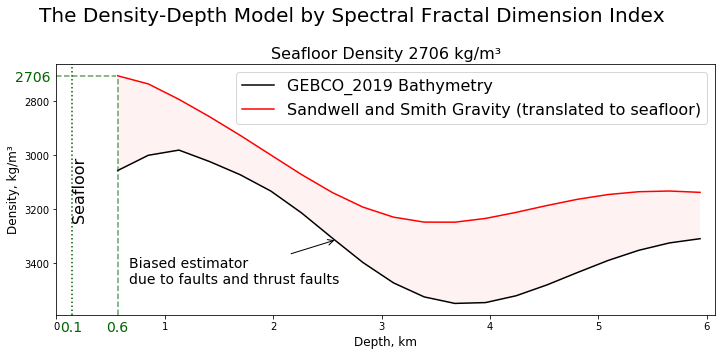

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10.5,5))

ax.plot(depths_seafloor, 1000*dem_fractality, c='black', label='GEBCO_2019 Bathymetry')
#ax.plot(depths, 1000*grv_fractality, c='gray', linestyle=':',
#        label='Sandwell and Smith Gravity (biased estimator)')
ax.plot(depths_seafloor, 1000*grv_fractality, c='red',
        label='Sandwell and Smith Gravity (translated to seafloor)')
ax.set_xlim([0,0.707*resolution*GAMMA])
ax.legend(loc='upper right', fontsize=16)
ax.set_xlabel('Depth, km',fontsize=12)
ax.set_ylabel('Density, kg/m³',fontsize=12)
ax.invert_yaxis()
#ax.grid()

ax.axvline(x=-dem.mean()/1000, ymin=0, ymax=1, color = 'darkgreen', ls='dotted')
ax.text(-dem.mean()/1000, (ax.get_ylim()[0]+ax.get_ylim()[1])/2,
        "Seafloor", rotation=90, verticalalignment='center',fontsize=16)

ax.axhline(y=1000*grv_fractality[0], xmin=0, xmax=.09, color = 'darkgreen', ls='--', alpha=0.6)
ax.text(-.38, 20+1000*grv_fractality[0], int(np.round(1000*grv_fractality[0])), color="darkgreen", fontsize=14)

ax.axvline(x=depths_seafloor[0], ymin=0, ymax=.95, color = 'darkgreen', ls='--', alpha=0.6)
ax.text(-0.11+depths_seafloor[0],3652, np.round(depths_seafloor[0],1), color="darkgreen", fontsize=14)

ax.text(-0.11-float(dem.mean())/1000,3652, np.round(-float(dem.mean())/1000,1), color="darkgreen", fontsize=14)

ax.fill_between(depths_seafloor, 1000*dem_fractality, 1000*grv_fractality,
                facecolor='red', alpha=.05, interpolate=True)

ax.annotate("Biased estimator\ndue to faults and thrust faults",
            xy=(.425, 0.3), xytext=(.11, 0.125), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="->"), fontsize=14)

plt.suptitle('The Density-Depth Model by Spectral Fractal Dimension Index',fontsize=20)
plt.title('Seafloor Density %d kg/m³' % int(np.round(1000*grv_fractality[0])),fontsize=16)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
#plt.savefig('Density Model by Fractal Dimension Index.jpg', dpi=150)
plt.show()